## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib as mp
from shapely.geometry import Point, Polygon
import altair as alt
import numpy as np
import requests
import json
import warnings
from matplotlib.colors import ListedColormap

alt.renderers.enable('notebook')
alt.themes.enable('opaque')

warnings.filterwarnings('ignore')
%matplotlib inline

## Import Dataset

["A Certificate of Occupancy"](https://data.lacity.org/A-Safe-City/Building-and-Safety-Certificate-of-Occupancy/3f9m-afei) is a document issued by the Department of Building and Safety certifying a building's compliance with applicable building codes and other laws, and indicating it to be in a condition suitable for occupancy. The data is cleaned for including only building related information and saved as ["Certificates of Occupancy AD Edited -Data.csv"](../Data/Certificates%20of%20Occupancy%20AD%20Edited%20-%20Data.csv) before conducting initial investigation. 

In [2]:
occupancy = pd.read_csv('../Data/Certificates of Occupancy AD Edited - Data.csv')

In [3]:
occupancy.permit_type.value_counts()

Bldg-New             10529
Bldg-Alter/Repair      830
Bldg-Addition          685
Name: permit_type, dtype: int64

There are three types of building related permits, they are: Bldg-New, Bldg-Alter/Repair, and Bldg-Addition. We're only interested in new buildings.

## Filter Data

In [4]:
new_building = occupancy[occupancy['permit_type']=='Bldg-New']

## Plot function

In [6]:
def bar_plot(data, ylabel, xlabel, size):
    fig, ax = plt.subplots(figsize=size)
    sns.barplot(data.index, data.values.ravel(), hue=data.values.ravel(), palette="Blues", dodge=False)
    
    ax.set_xlabel(xlabel, fontsize=20, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabel,fontsize=20, fontweight='black', color = '#333F4B')

    ax.tick_params(axis='both', which='major', labelsize=14,length=6)
    plt.xticks(np.arange(len(data.index)), data.index)
    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.015))
    ax.legend_.remove()

## Building types vs number of buildings

In [46]:
build_type = new_building.permit_subtype.value_counts()

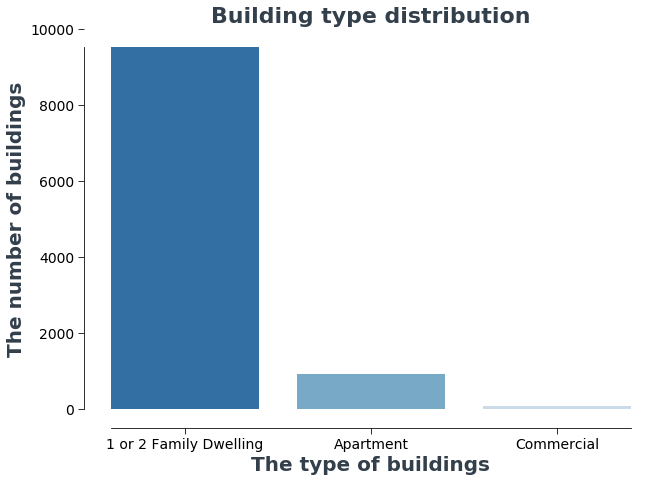

In [47]:
bar_plot(build_type, 'The number of buildings', 'The type of buildings',(10,7))
plt.title('Building type distribution', fontsize = 22,fontweight='black', color = '#333F4B');

The new buildings are mainly 1 or 2 Family Dwelling units.

## Building types vs number of housing units

In [51]:
unit_type = new_building.groupby('permit_subtype').agg({'homes':'sum'})

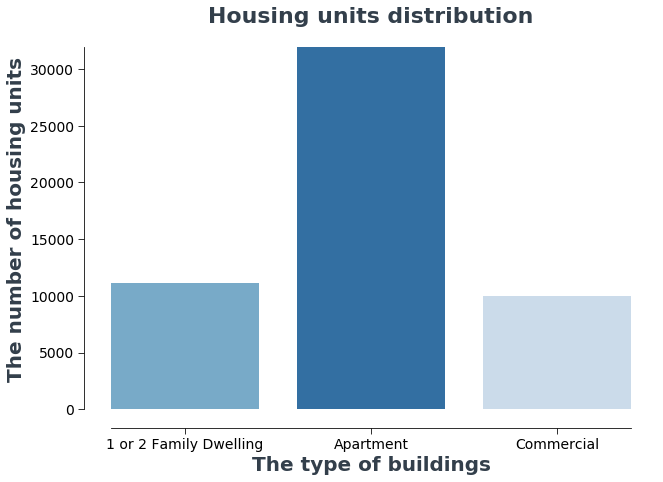

In [55]:
bar_plot(unit_type, 'The number of housing units', 'The type of buildings',(10,7))
plt.title('Housing units distribution', fontsize = 22,fontweight='black', color = '#333F4B');

- The most housing units are provided by Apartment buildings

In [39]:
permit_year = new_building.groupby('year').agg({'homes':'sum'})

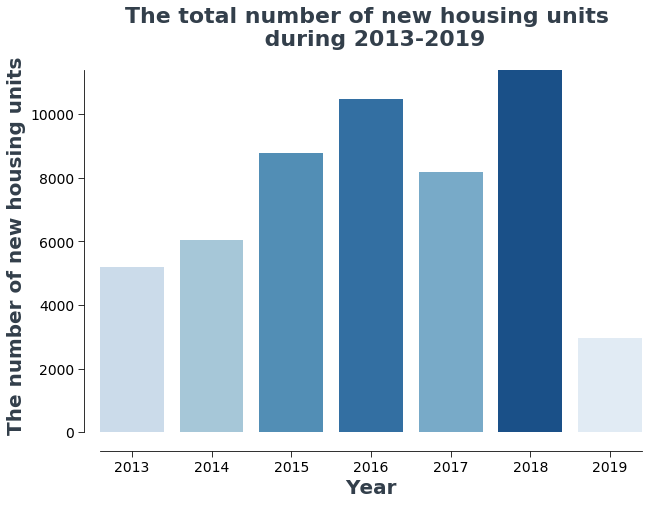

In [59]:
bar_plot(permit_year,'The number of new housing units ','Year',(10,7))
plt.title('The total number of new housing units \n during 2013-2019', fontsize = 22,fontweight='black', color = '#333F4B');

- The number of housing units increases over time during 2013 to 2016
- In 2017, the lower number of housing units are built than in 2016
- In 2018, the number of housing units increases again

## Neighborhood level mapping

The occupancy dataset doesn't provide the information which neighborhood the building is located. To be consistent with other analysis and better represent data, the neighborhood is defined by matching Geo coordinate with neighborhood polygon. 

- LA neighborhood shapefiles

In [10]:
LA_shape = gpd.read_file('../Data/LA_Times_Neighborhoods/LA_Times_Neighborhoods.shp')

- convert the longitude and latitude information to a set format, for example: (-118,34)

In [11]:
cord = [(x, y) for x,y in zip(new_building['lon'],new_building['lat'])]

- `Point` function is used to define the geological locations on the map

In [12]:
point = [Point(x) for x in cord] 

- Iterate through every building geo-locations in the dataset, check if the point is `within` any given neighborhood polygons.

In [13]:
neighborhood = []
for i in range(len(point)):
    name = LA_shape[LA_shape['geometry'].apply(lambda x: point[i].within(x))]['name'].values
    neighborhood.append(name)

- Add a new column `neighborhood` to `new_building` dataframe

In [14]:
new_building['neighborhood']=[x[0] if len(x)!=0 else 'None' for x in neighborhood]

## Pivot table

### Commercial buildings and neighborhood

In [15]:
nei_permit = pd.pivot_table(new_building, values = 'permit_number',index='neighborhood', columns='permit_subtype', aggfunc='count', fill_value=0)

In [16]:
nei_comm = nei_permit['Commercial'].sort_values(ascending=False)[:9]

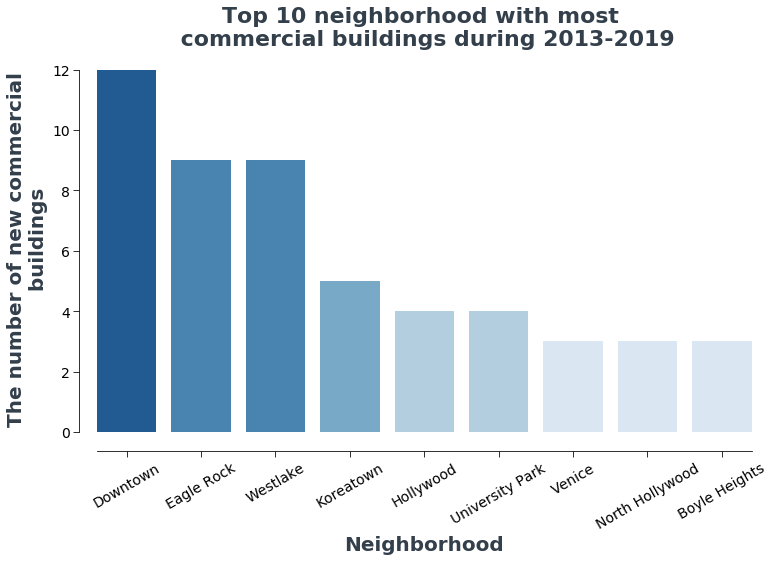

In [17]:
bar_plot(nei_comm,'The number of new commercial  \n buildings','Neighborhood',(12,7))
plt.xticks(rotation=30);
plt.title('Top 10 neighborhood with most \n commercial buildings during 2013-2019', fontsize = 22,fontweight='black', color = '#333F4B');

- The most commercial buildings are built in "Downtown" LA
- There are limited number of commercial buildings are constructed during 2013 to present (range from 0 to 12)

### Apartment buildings and neighborhood

In [18]:
nei_apart = nei_permit['Apartment'].sort_values(ascending=False)[:9]

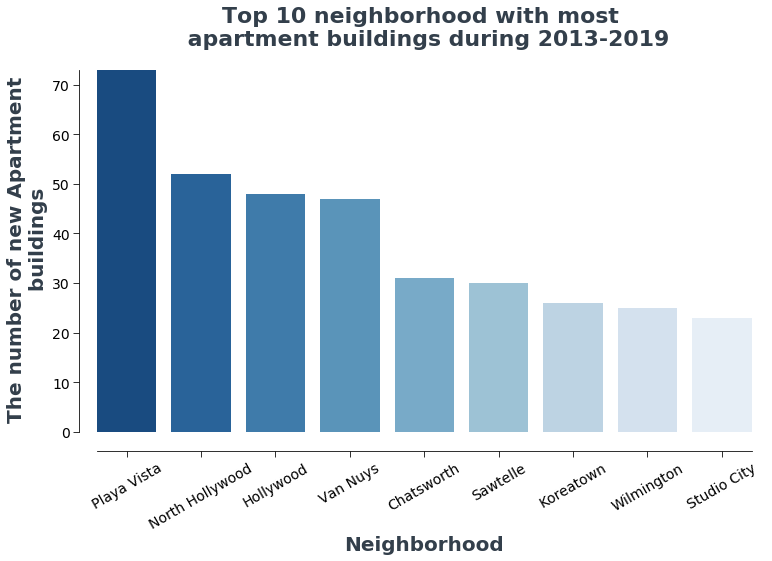

In [19]:
bar_plot(nei_apart,'The number of new Apartment  \n buildings','Neighborhood',(12,7))
plt.xticks(rotation=30);
plt.title('Top 10 neighborhood with most \n apartment buildings during 2013-2019', fontsize = 22,fontweight='black', color = '#333F4B');

- The most Apartment buildings are built in "Playa Vista"

### Family Dwelling building and neighborhood

In [20]:
nei_family = nei_permit['1 or 2 Family Dwelling'].sort_values(ascending=False)[:9]

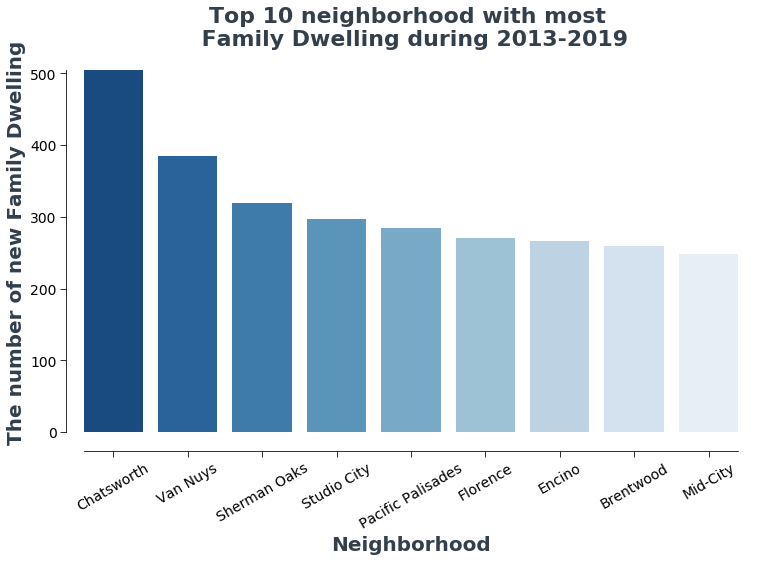

In [21]:
bar_plot(nei_family,'The number of new Family Dwelling','Neighborhood',(12,7))
plt.xticks(rotation=30);
plt.title('Top 10 neighborhood with most \n Family Dwelling during 2013-2019', fontsize = 22,fontweight='black', color = '#333F4B');

- The most Family Dwellings are built in "Chatsworth"

In [22]:
nei_year = pd.pivot_table(new_building, values = 'permit_type',index='neighborhood', columns='year', aggfunc='count', fill_value=0)
nei_year.reset_index(level=0, inplace=True)

In [23]:
nei_year.head()

year,neighborhood,2013,2014,2015,2016,2017,2018,2019
0,Adams-Normandie,0,0,2,0,0,5,1
1,Arleta,0,3,1,2,1,2,0
2,Arlington Heights,0,2,0,2,6,2,0
3,Atwater Village,11,0,3,5,14,3,0
4,Baldwin Hills/Crenshaw,1,0,0,1,0,1,0


## Neighborhood Level Housing Supply Map

### Define functions to acquire `geojson` file of LA neighborhood 

In [24]:
def download_json():
    url = "https://opendata.arcgis.com/datasets/d6c55385a0e749519f238b77135eafac_0.geojson"
    resp = requests.get(url)
    return resp.json()


In [25]:
la_json = download_json()

### Convert the `geojson` to dataframe

In [26]:
gdf = gpd.GeoDataFrame.from_features((la_json))

In [27]:
gdf.rename(columns={'name':'neighborhood'},inplace=True)

In [28]:
gdf = gdf.merge(nei_year, on='neighborhood', how='left')

### Find the centroid to insert labels

In [29]:
gdf['center_lon'] = gdf['geometry'].centroid.x
gdf['center_lat'] = gdf['geometry'].centroid.y

- Rename the columns

In [30]:
gdf.rename(columns={
    2013:'2013',
    2014:'2014',
    2015:'2015',
    2016:'2016',
    2017:'2017',
    2018:'2018',
    2019:'2019'
},inplace=True)

- Prepare data to be used for Altair Map

In [31]:
choro_json = json.loads(gdf.to_json())
choro_data = alt.Data(values=choro_json['features'])

### Functions for generating map

In [60]:
def gen_map(geodata, color_column, title):
    '''Generates LA map with population choropleth and neighborhood labels'''
    # Add Base Layer
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1,
    ).encode(
    ).properties(
        width=500,
        height=800
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
        fill='lightgray',
        stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme='yelloworangered'),
                  title = "The number of new buildings"),
        tooltip = ['properties.neighborhood:O',color_column + ':Q']
    )
    # Add Labels Layer
    labels = alt.Chart(geodata).mark_text(baseline='top'
                                          
                                          
     ).properties(
        width=100,
        height=200
     ).encode(
         longitude='properties.center_lon:Q',
         latitude='properties.center_lat:Q',
         text='properties.neighborhood:O',
         size=alt.value(7),
         opacity=alt.value(1)
     )

    return base + choro + labels


In [61]:
map_2013= gen_map(geodata=choro_data, color_column='properties.2013', title='New Homes built in 2013')
map_2014= gen_map(geodata=choro_data, color_column='properties.2014', title='New Homes built in 2014')
map_2015= gen_map(geodata=choro_data, color_column='properties.2015', title='New Homes built in 2015')
map_2016= gen_map(geodata=choro_data, color_column='properties.2016', title='New Homes built in 2016')
map_2017= gen_map(geodata=choro_data, color_column='properties.2017', title='New Homes built in 2017')
map_2018= gen_map(geodata=choro_data, color_column='properties.2018', title='New Homes built in 2018')
map_2019= gen_map(geodata=choro_data, color_column='properties.2019', title='New Homes built in 2019')

In [62]:
final_map = map_2013| map_2014|map_2015|map_2016|map_2017|map_2018|map_2019

In [63]:
final_map.save(fp = '../Image/building_map.html')

## (Optional) Family Dwelling's story numbers

In [36]:
family = new_building[new_building['permit_subtype']=='1 or 2 Family Dwelling']

In [37]:
family_year = pd.pivot_table(family, values = 'permit_number',index='year', columns='stories', aggfunc='count', fill_value=0)

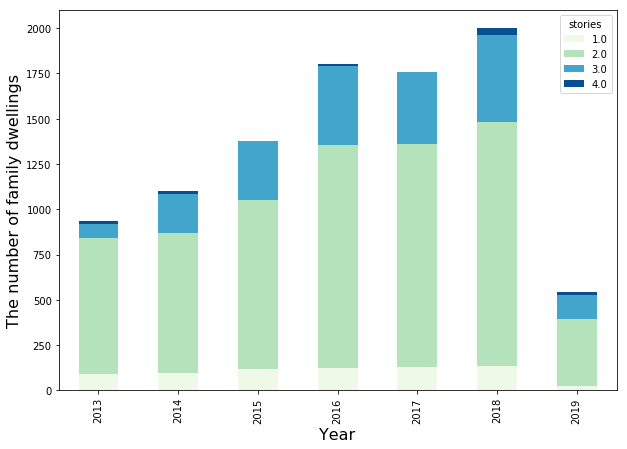

In [38]:
family_year.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 20)),figsize=(10,7)
                 ,grid='off'
                );
plt.xlabel('Year', fontsize=16);
plt.ylabel('The number of family dwellings', fontsize=16);

- The most popular family homes are 2-story home.
- The number of two and three story homes are increasing over time
- The number of one-story homes hasn't increased much over time